<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/colab_gan_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN for the Embroidered Patterns

This project shows the process and the results of the generation of the patterns for the embroidered Ukrainian towels' patterns using the scraped data.


I have first conducted a research on the existed pre-trained GANs to do transfer learning, since I only have ~650 images, therefore, only building on top of the pre-trained model would be effective for this data size.


I have been training on Google Colab Pro since the model takes hours to produce the good quality results. 

I have selected a small size of images 64x64 to see whether the model can pick up the necessary patterns and it successfully did. 

The notebook presents multiple parts:


*   Data Pre-processing
*   Model Initialization
*   Resuming of the model after the disconnection from Google Colab
*  Examples of generated images


## Resources used to learn the model

1. The youtube video outlining the process of building the model on the colab using drive as a storage: https://www.youtube.com/watch?v=L3JLzoe-dJU
2. Tutorials on doing transfer learning for StyleGAN:


*   https://www.analyticsvidhya.com/blog/2020/12/
*   https://towardsdatascience.com/a-shortcut-to-achieving-high-quality-gan-results-bca64a5b9394 

In [ ]:
!nvidia-smi

Sat Oct 15 07:28:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Setting Up the Environment and Mounting Drive

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


You must also upports StyleGAN.

In [ ]:
#installing NVIDIA StyleGAN2 ADA PyTorch
#importing the libraries 

# Works fine on t4
!pip install torch==1.8.1 torchvision==0.9.1
# This has to be run if we want to use A100
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# !pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
import os
from tqdm import tqdm
import cv2
from PIL import Image
BASE_SIZE = (256, 256)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 17.4 MB 26.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.8.1 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.8.1 which is incompatible.
fatal: destination path 'stylegan2-ada-pytorch' already exist

## Image Pre-processing

In this section, I am uploading images to Drive, converting them to the same color scheme and size. Then I convert them in the format necessary to input in the training function. 

In [ ]:

# converting the images to the correct size and storing in a separate folder on drive 
path = "/content/drive/MyDrive/data/gan/training_data/"
save_path = "/content/drive/MyDrive/data/gan/training_data/"
for filename in tqdm(os.listdir(path),desc ='reading images ...'):
  image = Image.open(path+filename)
  if image.size != BASE_SIZE:
    image = image.resize(BASE_SIZE)
  if image.mode != "RGB":
    image = image.convert("RGB")
  # print(image.size)
  image.save(save_path+filename, image.format)

reading images ...: 100%|██████████| 3748/3748 [01:36<00:00, 38.78it/s] 


In [ ]:

#cleaning up the color depth 
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/drive/MyDrive/data/gan/training_data'
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = (256,256)
for file in tqdm(files):
  file2 = os.path.join(IMAGE_PATH,file)
  img = Image.open(file2)
  sz = img.size
  if base_size and sz!=base_size:
    print(f"Inconsistant size:{img.size} {file2}")
  elif img.mode!='RGB':
    print(f"Inconsistant color format: {file2}")
  else:
    base_size = sz


  0%|          | 0/3748 [00:00<?, ?it/s]

In [ ]:
#converting the images in the tf format that is then inputted in the model
!python /content/stylegan2-ada-pytorch/dataset_tool.py --source /content/drive/MyDrive/data/gan/training_data --dest /content/drive/MyDrive/data/gan/datasets/training_dataset

100% 3748/3748 [00:45<00:00, 82.62it/s]


In [ ]:
#clearing created dataset if I need to rerun the converting in the cell above
!rm -R /content/drive/MyDrive/data/gan/datasets/training_dataset/*

## Training for the First time

Using the paths for the drive folders to take from and to store the logs, fakes, and .pkl files of the models. Every 25 ticks, I am storing the results to be able to continue retrieving once I resume model training. 

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/2800_batch_results"
DATA = "/content/drive/MyDrive/data/gan/datasets/training_dataset"
SNAP = 25

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py --snap {SNAP} --outdir {EXPERIMENTS} --data {DATA}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 25,
  "network_snapshot_ticks": 25,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/data/gan/datasets/training_dataset",
    "use_labels": false,
    "max_size": 3748,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_ba

## Resume Training

My model got interrupted after 8.5 hours of working. I was observing the "fid50k_full" metrtic that looks at the distance across the datasets as a measure of performance of the model. Lower values indicate smaller distance, therefore, the model can pick up the patterns better. At the last snap, the decrease was only from from 68.67 to 64.94 which is small, therefore, I was suspecting that the model would not improve much more. However, I resumed training to see whether it was not the case. 



The metric decreased almost insignificanlty therefore, I decided to terminate the training since it would not improve much afterwards. The score around 60 is not good, but this has to do with the fact that I only have 600 images and I decided to run the model on the images of a very small size 64x64. This was done to see whether the model is able to pick up the patterns in the towels and then would be improved and trained with more data and higher quality images. 

In [ ]:

#continue training using the last retrieved network snapshot
import os

EXPERIMENTS = "/content/drive/MyDrive/data/gan/2800_batch_results"
DATA = "/content/drive/MyDrive/data/gan/datasets/training_dataset"
NETWORK = "network-snapshot-000400.pkl"
RESUME = os.path.join(EXPERIMENTS, "00009-training_dataset-auto1-resumecustom/", NETWORK)
SNAP = 25

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py --snap {SNAP} --resume {RESUME} --outdir {EXPERIMENTS} --data {DATA}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 25,
  "network_snapshot_ticks": 25,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/data/gan/datasets/training_dataset",
    "use_labels": false,
    "max_size": 3748,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_ba

## Summary 

The model was built successfully and it picked up the patterns very well, given the quality of the input data. 


Here is the gif showing the process of transofrmation of the images: 

Since the Assignment is submitted as a pdf, here is the link to the shared gif: https://drive.google.com/file/d/1qxRrSPF0Fqls1VuZQOKYeoI-i4uncUR5/view?usp=sharing 







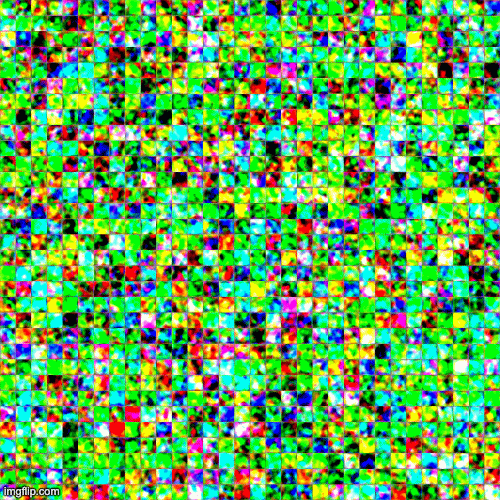

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

gifPath = "/content/drive/MyDrive/data/gan/gif.gif" # please paste the whole path from Step 2-6


# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='gif')

I have also generated the images from the model using the code below. They 50 examples are stored here: https://drive.google.com/file/d/11c07zrec2JFq2Cp3zRoKynP3USKwmLoj/view?usp=sharing


Here is one embedded example: 

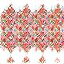



In conclusion, I have completed the exploratory analysis of whether StyleGAN is a good model to use to generate the patterns and it is proven effective. Now, to get high quality results, I will need to get more data and to train longer with the higher resolution of the model. 